<a href="https://colab.research.google.com/github/yuepingwang/sngan-projection/blob/master/cGAN_Generate_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 130824 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [6]:
!pip install torch torchvision
!pip install scipy pyamg

import numpy as np

import torch
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from __future__ import print_function

     |████████████████████████████████| 6.4MB 4.4MB/s 
     |████████████████████████████████| 153kB 45.3MB/s 


In [0]:
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
# import model metadata
import json

with open("drive/cGan2/args.json") as f:
  args = json.load(f)

In [0]:
class_weights = torch.tensor([0.,0.,0.,0.05,0.,0.95]).to(device)


In [64]:

# from utils.py, with modification
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

import math

device = torch.device('cuda')

# "categorical CBN" begin
class ConditionalBatchNorm2d(nn.BatchNorm2d):
    """Conditional Batch Normalization"""

    def __init__(self, num_features, eps=1e-05, momentum=0.1,
                 affine=False, track_running_stats=True):
        super(ConditionalBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats
        )

    def forward(self, input, weight, bias, **kwargs):
        self._check_input_dim(input)

        exponential_average_factor = 0.0

        if self.training and self.track_running_stats:
            self.num_batches_tracked += 1
            if self.momentum is None:  # use cumulative moving average
                exponential_average_factor = 1.0 / self.num_batches_tracked.item()
            else:  # use exponential moving average
                exponential_average_factor = self.momentum

        output = F.batch_norm(input, self.running_mean, self.running_var,
                              self.weight, self.bias,
                              self.training or not self.track_running_stats,
                              exponential_average_factor, self.eps)
        if weight.dim() == 1:
            weight = weight.unsqueeze(0)
        if bias.dim() == 1:
            bias = bias.unsqueeze(0)
        size = output.size()
        weight = weight.unsqueeze(-1).unsqueeze(-1).expand(size)
        bias = bias.unsqueeze(-1).unsqueeze(-1).expand(size)
        return weight * output + bias


class CategoricalConditionalBatchNorm2d(ConditionalBatchNorm2d):

    def __init__(self, num_classes, num_features, eps=1e-5, momentum=0.1,
                 affine=False, track_running_stats=True):
        super(CategoricalConditionalBatchNorm2d, self).__init__(
            num_features, eps, momentum, affine, track_running_stats
        )
        self.weights = nn.Embedding(num_classes, num_features)
        self.biases = nn.Embedding(num_classes, num_features)
        
        self.num_classes = num_classes
        self.num_features = num_features
        
        self.device = device

        self._initialize()

    def _initialize(self):
        init.ones_(self.weights.weight.data)
        init.zeros_(self.biases.weight.data)

    # Change the original CBN layer by passing in a list of class-encoding vectors
    # and take linear combination of weights by coefficients specified in the "class_weights" list
    def forward(self, input, c, **kwargs):
      
        weight = self.weights(c[0])*class_weights[0].to(self.device)
        bias = self.biases(c[0])*class_weights[0].to(self.device)
        
        n = class_weights.size()
        if class_weights.size(0)>1:
          for i in [1,class_weights.size(0)-1]:
            weight += self.weights(c[0])*class_weights[i]
            bias += self.biases(c[0])*class_weights[i]

        return super(CategoricalConditionalBatchNorm2d, self).forward(input, weight, bias)


if __name__ == '__main__':
    """Forward computation check."""
    import torch
    size = (3, 3, 12, 12)
    batch_size, num_features = size[:2]
    print('# Affirm embedding output')
    naive_bn = nn.BatchNorm2d(3)
    idx_input = torch.tensor([1, 2, 0], dtype=torch.long)
    embedding = nn.Embedding(3, 3)
    weights = embedding(idx_input)
    print('# weights size', weights.size())
    empty = torch.tensor((), dtype=torch.float)
    running_mean = empty.new_zeros((3,))
    running_var = empty.new_ones((3,))

    naive_bn_W = naive_bn.weight
    # print('# weights from embedding | type {}\n'.format(type(weights)), weights)
    # print('# naive_bn_W | type {}\n'.format(type(naive_bn_W)), naive_bn_W)
    input = torch.rand(*size, dtype=torch.float32)
    print('input size', input.size())
    print('input ndim ', input.dim())

    _ = naive_bn(input)

    print('# batch_norm with given weights')

    try:
        with torch.no_grad():
            output = F.batch_norm(input, running_mean, running_var,
                                  weights, naive_bn.bias, False, 0.0, 1e-05)
    except Exception as e:
        print("\tFailed to use given weights")
        print('# Error msg:', e)
        print()
    else:
        print("Succeeded to use given weights")

    print('\n# Batch norm before use given weights')
    with torch.no_grad():
        tmp_out = F.batch_norm(input, running_mean, running_var,
                               naive_bn_W, naive_bn.bias, False, .0, 1e-05)
    weights_cast = weights.unsqueeze(-1).unsqueeze(-1)
    weights_cast = weights_cast.expand(tmp_out.size())
    try:
        out = weights_cast * tmp_out
    except Exception:
        print("Failed")
    else:
        print("Succeeded!")
        print('\t {}'.format(out.size()))
        print(type(tuple(out.size())))

    print('--- condBN and catCondBN ---')

    catCondBN = CategoricalConditionalBatchNorm2d(3, 3)
    output = catCondBN(input, idx_input)

    assert tuple(output.size()) == size

    condBN = ConditionalBatchNorm2d(3)

    idx = torch.tensor([1], dtype=torch.long)
    out = catCondBN(input, idx)

    print('cat cond BN weights\n', catCondBN.weights.weight.data)
    print('cat cond BN biases\n', catCondBN.biases.weight.data)
# "categorical CBN" end

# "resblocks.py" begin
def _upsample(x):
    h, w = x.size()[2:]
    return F.interpolate(x, size=(h * 2, w * 2), mode='bilinear')


class Block(nn.Module):

    def __init__(self, in_ch, out_ch, h_ch=None, ksize=3, pad=1,
                 activation=F.relu, upsample=False, num_classes=0):
        super(Block, self).__init__()

        self.activation = activation
        self.upsample = upsample
        self.learnable_sc = in_ch != out_ch or upsample
        if h_ch is None:
            h_ch = out_ch
        self.num_classes = num_classes

        # Register layrs
        self.c1 = nn.Conv2d(in_ch, h_ch, ksize, 1, pad)
        self.c2 = nn.Conv2d(h_ch, out_ch, ksize, 1, pad)
        if self.num_classes > 0:
            self.b1 = CategoricalConditionalBatchNorm2d(
                num_classes, in_ch)
            self.b2 = CategoricalConditionalBatchNorm2d(
                num_classes, h_ch)
        else:
            self.b1 = nn.BatchNorm2d(in_ch)
            self.b2 = nn.BatchNorm2d(h_ch)
        if self.learnable_sc:
            self.c_sc = nn.Conv2d(in_ch, out_ch, 1)

    def _initialize(self):
        init.xavier_uniform_(self.c1.weight.tensor, gain=math.sqrt(2))
        init.xavier_uniform_(self.c2.weight.tensor, gain=math.sqrt(2))
        if self.learnable_sc:
            init.xavier_uniform_(self.c_sc.weight.tensor, gain=1)

    def forward(self, x, y=None, z=None, **kwargs):
        return self.shortcut(x) + self.residual(x, y, z)

    def shortcut(self, x, **kwargs):
        if self.learnable_sc:
            if self.upsample:
                h = _upsample(x)
            h = self.c_sc(h)
            return h
        else:
            return x

    def residual(self, x, y=None, z=None, **kwargs):
        if y is not None:
            h = self.b1(x, y, **kwargs)
        else:
            h = self.b1(x)
        h = self.activation(h)
        if self.upsample:
            h = _upsample(h)
        h = self.c1(h)
        if y is not None:
            h = self.b2(h, y, **kwargs)
        else:
            h = self.b2(h)
        return self.c2(self.activation(h))
# "resblocks.py" end

class ResNetGenerator(nn.Module):
    """Generator generates 64x64."""

    def __init__(self, num_features=64, dim_z=128, bottom_width=4,
                 activation=F.relu, num_classes=0, distribution='normal'):
        super(ResNetGenerator, self).__init__()
        self.num_features = num_features
        self.dim_z = dim_z
        self.bottom_width = bottom_width
        self.activation = activation
        self.num_classes = num_classes
        self.distribution = distribution

        self.l1 = nn.Linear(dim_z, 16 * num_features * bottom_width ** 2)

        self.block2 = Block(num_features * 16, num_features * 8,
                            activation=activation, upsample=True,
                            num_classes=num_classes)
        self.block3 = Block(num_features * 8, num_features * 4,
                            activation=activation, upsample=True,
                            num_classes=num_classes)
        self.block4 = Block(num_features * 4, num_features * 2,
                            activation=activation, upsample=True,
                            num_classes=num_classes)
        self.block5 = Block(num_features * 2, num_features,
                            activation=activation, upsample=True,
                            num_classes=num_classes)
        self.b6 = nn.BatchNorm2d(num_features)
        self.conv6 = nn.Conv2d(num_features, 3, 1, 1)

    def _initialize(self):
        init.xavier_uniform_(self.l1.weight.tensor)
        init.xavier_uniform_(self.conv7.weight.tensor)

    def forward(self, z, y=None, **kwargs):
        h = self.l1(z).view(z.size(0), -1, self.bottom_width, self.bottom_width)
        for i in range(2, 6):
            h = getattr(self, 'block{}'.format(i))(h, y, **kwargs)
        h = self.activation(self.b6(h))
        return torch.tanh(self.conv6(h))

# Affirm embedding output
# weights size torch.Size([3, 3])
input size torch.Size([3, 3, 12, 12])
input ndim  4
# batch_norm with given weights
	Failed to use given weights
# Error msg: weight should contain 3 elements not 9


# Batch norm before use given weights
Succeeded!
	 torch.Size([3, 3, 12, 12])
<class 'tuple'>
--- condBN and catCondBN ---
cat cond BN weights
 tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
cat cond BN biases
 tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])


In [0]:
# from gen import ResNetGenerator
# define/import generator class
G = ResNetGenerator(
    args['gen_num_features'], args['gen_dim_z'], args['gen_bottom_width'],
    num_classes=6, distribution=args['gen_distribution']
)
opt_gen = torch.optim.Adam(
    G.parameters(), args['lr'], (args['beta1'], args['beta2'])
)


In [0]:
# Load trained generator weights #
def load_model_optim(checkpoint_path, model=None, optim=None):
    ckpt = torch.load(checkpoint_path)
    if model is not None:
        model.load_state_dict(ckpt['model'])
    if optim is not None:
        optim.load_state_dict(ckpt['opt'])
    return model, optim

G, opt_gen = load_model_optim("drive/cGan2/gen_latest.pth.tar", G, opt_gen)

In [0]:
import torch as _torch

dtype = 'CUDA' # pick CUDA or CPU dtype
class DeviceAgnosticModule(object):
    def __getattribute__(self, name):
        obj = getattr(torch, name)
        if not callable(obj):
            return obj
        return functools.partial(obj, dtype=dtype)

In [0]:
def cast(cuda):
  if cuda:
    return lambda x: x.cuda()
  else:
    return lambda x: x


torch.cast = cast(False)
a = G.cuda()
   
 

In [0]:
print(G)

In [0]:
def generate_images(gen, device, batch_size=64, dim_z=128, distribution=None,
                    num_classes=None, class_id=None):
    
    z = sample_z(batch_size, dim_z, device, distribution)
    if num_classes is None and class_id is None:
        y = None
    elif num_classes is not None:
        y = torch.ones([num_classes,batch_size], dtype=torch.long).to(device)
    elif class_id is not None:
        y = torch.ones([num_classes], dtype=torch.float64).to(device)
        for _i in range(0, num_classes-1):
          y[_i] = y[_i]*class_weights[_i]
    else:
        y = None
    with torch.no_grad():
        fake = gen(z, y)

    return fake
  
def sample_z(batch_size, dim_z, device, distribution=None):
   
    if distribution is None:
        distribution = 'normal'
    if distribution == 'normal':
        return torch.empty(batch_size, dim_z, dtype=torch.float32, device=device).normal_()
    else:
        return torch.empty(batch_size, dim_z, dtype=torch.float32, device=device).uniform_()


def sample_pseudo_labels(num_classes, batch_size, device):
   
    pseudo_labels = torch.from_numpy(
        numpy.random.randint(low=0, high=num_classes, size=(batch_size))
    )
    pseudo_labels = pseudo_labels.type(torch.long).to(device)
    return pseudo_labels


def save_images(count, root, fake):

    fake_path = os.path.join(
        'fake_{}.png'.format(count)
    )
    torchvision.utils.save_image(
        fake, fake_path, nrow=4, normalize=True, scale_each=True
    )
    shutil.copy(fake_path, os.path.join(root, 'fake_interpolation.png'))
    

def load_model_optim(checkpoint_path, model=None, optim=None):

    ckpt = torch.load(checkpoint_path)
    if model is not None:
        model.load_state_dict(ckpt['model'])
    if optim is not None:
        optim.load_state_dict(ckpt['opt'])
    return model, optim


def load_model(checkpoint_path, model):

    return load_model_optim(checkpoint_path, model, None)[0]


def load_optim(checkpoint_path, optim):

    return load_model_optim(checkpoint_path, None, optim)[1]

In [70]:
# import numpy as numpy
device = torch.device('cuda')
fake = generate_images(G, device, batch_size=64, dim_z=128, distribution=None,
                    num_classes=6, class_id=None)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [0]:
# import torchvision
# torchvision.utils.make_grid(fake, nrow=4, normalize=True, scale_each=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


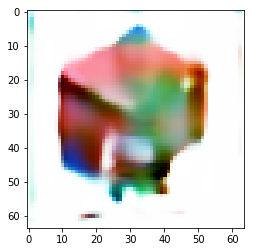

In [48]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
show(fake[0].cpu())

In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
fake1 = fake[0]
img = fake.cpu().numpy()
plt.imshow(img[1,1,:,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


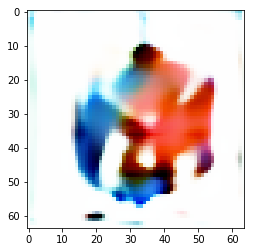

In [61]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
show(fake[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


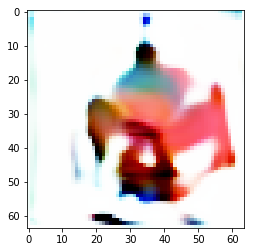

In [104]:
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
show(fake[7].cpu())